<a href="https://colab.research.google.com/github/aimalz/CASTORpz/blob/main/TheLastMetric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Research/CASTORpz

/content/drive/MyDrive/Research/CASTORpz


In [3]:
from astropy.table import Table
prepend = '/content/drive/MyDrive/Research/CASTORpz/'
unp = Table.read(prepend+"unperturbed_mags.fits")
print(len(unp))

698211


In [4]:
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!nvcc --version

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [5]:
!pip install astropy pzflow corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.4 MB/s eta 0:00:00


In [6]:
from pzflow import Flow
import jax.numpy as jnp
import pandas as pd 
import numpy as np
import pickle
import corner
import matplotlib.pyplot as plt
from astropy.table import Table
from pzflow import Flow, FlowEnsemble
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling, ColorTransform, InvSoftplus, RollingSplineCoupling, ShiftBounds

In [7]:
# load data
def getTrueY(test_cat, mag_col_names, y_col_name):
    test_cat = Table(test_cat, masked=True, copy=True)
    # remove nans
    for col in mag_col_names:
        test_cat[col].mask = np.isnan(test_cat[col].data) | test_cat[col].mask
        test_cat = test_cat[~test_cat[col].mask] # then remove nans from test set
            
    true_y = test_cat[y_col_name]
    return true_y.filled()

In [8]:
unp = Table.read(prepend+"unperturbed_mags.fits").to_pandas()#.set_index('ID')
mock = Table.read(prepend+"ext_phot.fits").to_pandas()#.set_index('ID')
# mask = unp["Euclid_VIS_MAG"] <= 24.5
# mock

In [ ]:
mock.columns

Index(['ID', 'photoz', 'castor_uv_MAG', 'castor_uv_MAGERR', 'castor_u_MAG',
       'castor_u_MAGERR', 'castor_g_MAG', 'castor_g_MAGERR', 'LSST_u_MAG',
       'LSST_u_MAGERR', 'LSST_g_MAG', 'LSST_g_MAGERR', 'LSST_r_MAG',
       'LSST_r_MAGERR', 'LSST_i_MAG', 'LSST_i_MAGERR', 'LSST_z_MAG',
       'LSST_z_MAGERR', 'LSST_y_MAG', 'LSST_y_MAGERR', 'Euclid_Y_MAG',
       'Euclid_Y_MAGERR', 'Euclid_J_MAG', 'Euclid_J_MAGERR', 'Euclid_H_MAG',
       'Euclid_H_MAGERR', 'Roman_106_MAG', 'Roman_106_MAGERR', 'Roman_129_MAG',
       'Roman_129_MAGERR', 'Roman_158_MAG', 'Roman_158_MAGERR',
       'Roman_184_MAG', 'Roman_184_MAGERR', 'hlr', 'castor_uv_UNPMAG',
       'castor_u_UNPMAG', 'castor_g_UNPMAG'],
      dtype='object')

In [ ]:
unp.columns

Index(['ID', 'RA', 'DEC', 'ID_CLASSIC', 'photoz', 'lp_type', 'lp_NbFilt',
       'lp_zq', 'lp_model', 'lp_age', 'lp_dust', 'lp_Attenuation',
       'lp_mass_med', 'lp_mass_best', 'lp_SFR_med', 'lp_SFR_best',
       'lp_sSFR_med', 'lp_sSFR_best', 'castor_uv_MAG', 'castor_uv_MAGERR',
       'castor_u_MAG', 'castor_u_MAGERR', 'castor_g_MAG', 'castor_g_MAGERR',
       'LSST_u_MAG', 'LSST_u_MAGERR', 'LSST_g_MAG', 'LSST_g_MAGERR',
       'LSST_r_MAG', 'LSST_r_MAGERR', 'LSST_i_MAG', 'LSST_i_MAGERR',
       'LSST_z_MAG', 'LSST_z_MAGERR', 'LSST_y_MAG', 'LSST_y_MAGERR',
       'PanStarrs_g_MAG', 'PanStarrs_g_MAGERR', 'PanStarrs_r_MAG',
       'PanStarrs_r_MAGERR', 'PanStarrs_i_MAG', 'PanStarrs_i_MAGERR',
       'PanStarrs_z_MAG', 'PanStarrs_z_MAGERR', 'PanStarrs_y_MAG',
       'PanStarrs_y_MAGERR', 'Euclid_Y_MAG', 'Euclid_Y_MAGERR', 'Euclid_J_MAG',
       'Euclid_J_MAGERR', 'Euclid_H_MAG', 'Euclid_H_MAGERR', 'Euclid_VIS_MAG',
       'Euclid_VIS_MAGERR', 'Roman_062_MAG', 'Roman_062_MAGERR',
     

In [ ]:
# unp = Table(unp.as_array().byteswap().newbyteorder('=')).to_pandas()
# mock = Table(mock.as_array().byteswap().newbyteorder('=')).to_pandas()
# mask = unp["Euclid_VIS_MAG"] <= 24.5
# mock

In [17]:
# I guess now we have all the columns we need to make the various samples besides baseline. . .

test = pd.merge(mock, unp[['ID',"Euclid_VIS_MAG",
                          #  'Euclid_Y_MAG','Euclid_J_MAG','Euclid_H_MAG',
                          #  'Roman_062_MAG','Roman_087_MAG','Roman_106_MAG',
                          #  'Roman_129_MAG','Roman_146_MAG','Roman_158_MAG',
                          #  'Roman_184_MAG','Roman_213_MAG'
                           ]], on='ID')

In [18]:
test

,ID,photoz,castor_uv_MAG,castor_uv_MAGERR,castor_u_MAG,castor_u_MAGERR,castor_g_MAG,castor_g_MAGERR,LSST_u_MAG,LSST_u_MAGERR,...,Roman_129_MAGERR,Roman_158_MAG,Roman_158_MAGERR,Roman_184_MAG,Roman_184_MAGERR,hlr,castor_uv_UNPMAG,castor_u_UNPMAG,castor_g_UNPMAG,Euclid_VIS_MAG
0,1,1.5930,28.254729,0.448615,25.992022,0.119891,25.826789,0.142720,25.979669,0.153905,...,0.079810,24.962978,0.080935,24.937529,0.121715,0.260364,27.683381,26.083223,25.933979,25.896338
1,2,0.1151,27.394224,0.615400,27.408074,0.567899,27.149037,0.510590,27.197911,0.752778,...,0.299143,26.447771,0.391600,26.655561,0.524696,0.315376,27.844114,27.658546,27.159357,26.908188
2,3,0.2211,23.793081,0.024148,23.874296,0.025684,23.519322,0.023301,23.881677,0.024495,...,0.019907,23.333492,0.022997,23.273987,0.033543,0.341474,23.826591,23.880792,23.514348,23.203628
3,5,2.8698,28.021874,3.790039,27.130343,0.264546,25.744500,0.114967,26.287686,0.258137,...,0.116011,25.421107,0.096367,25.352837,0.137380,0.222228,30.184010,27.146193,25.835429,25.858953
4,6,1.5139,NaN,1.372448,27.405443,0.434689,28.154684,0.457488,27.520027,0.855990,...,0.176897,26.544889,0.180882,26.306724,0.316326,0.150308,29.431319,28.055567,27.741206,27.601569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698206,964429,0.5593,23.297370,0.016245,23.364542,0.016829,23.572652,0.020839,23.409792,0.015035,...,0.014529,23.769582,0.028268,23.826702,0.043382,0.273552,23.300088,23.364395,23.537918,23.286846
698207,964437,1.7660,26.031585,0.377502,26.675457,0.431746,26.057066,0.488259,26.803141,0.365876,...,0.007441,20.969675,0.005681,20.735093,0.006624,0.676122,26.513011,26.562687,26.311562,24.614821
698208,964439,0.3207,26.235569,0.107262,25.688785,0.084903,25.308072,0.074601,25.569262,0.122167,...,0.055601,24.817459,0.052815,24.704142,0.078025,0.218479,26.181223,25.817343,25.344343,24.647086
698209,964440,0.0490,28.452931,86.993753,26.939224,5.680374,NaN,1.580289,27.796012,3.360202,...,0.168206,24.057227,0.196020,24.062430,0.267246,1.296759,31.731963,28.668804,26.889119,25.342216


In [19]:
CASTOR_baseline = Table.from_pandas(test[(test["Euclid_VIS_MAG"] <= 24.5) & (test["LSST_r_MAG"] >= 17.5)])#[mask]#Table.from_pandas(mock[mask]) #ignoring training data outside the Euclid flux limit
# idcol =  CASTOR_baseline['ID']
# CASTOR_baseline = Table(CASTOR_baseline.as_array().byteswap().newbyteorder('=')).to_pandas()[CASTOR_baseline.columns[1:]]
# print(CASTOR_baseline.columns)
# CASTOR_baseline['ID'] = idcol.astype(int).to_numpy().byteswap().newbyteorder('=')
# colnames = CASTOR_baseline.columns
# print(colnames)
# CASTOR_baseline = pd.DataFrame(CASTOR_baseline.to_numpy().byteswap().newbyteorder('='), columns=colnames)
# CASTOR_baseline = CASTOR_baseline.set_index('ID')
# CASTOR_baseline

In [20]:
names_phot = ["ID", "photoz",
              "LSST_g_MAG", "LSST_g_MAGERR", 
              "LSST_r_MAG", "LSST_r_MAGERR",
              "LSST_i_MAG", "LSST_i_MAGERR", 
              "LSST_z_MAG", "LSST_z_MAGERR",
              "castor_uv_MAG", "castor_uv_MAGERR", 
              "castor_u_MAG", "castor_u_MAGERR", 
              "castor_g_MAG", "castor_g_MAGERR",
              "Euclid_VIS_MAG",
                           'Euclid_Y_MAG','Euclid_J_MAG','Euclid_H_MAG']
                          #,
                          #  'Roman_062_MAG','Roman_087_MAG','Roman_106_MAG',
                          #  'Roman_129_MAG','Roman_146_MAG','Roman_158_MAG',
                          #  'Roman_184_MAG','Roman_213_MAG']
available_os = ["CASTOR-only", "LSST-only", "Euclid-only", #"Roman-only",
"LSST+CASTOR", "Euclid+CASTOR", #"Roman+CASTOR",
"Euclid+LSST", "Euclid+LSST+CASTOR"
]
names = available_os

In [21]:
# os_names = dict(zip(available_os, names))
# colors = ["k"] #, "plum", "cornflowerblue", "#2ca02c", "gold", "tomato"]
# os_colors = dict(zip(available_os, colors))

In [22]:
# put data in expected format for TLM

LSST_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAG")
LSST_r_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAG")
LSST_i_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAG")
LSST_z_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAG")

# LSST_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAGERR")
# LSST_r_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAGERR")
# LSST_i_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAGERR")
# LSST_z_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAGERR")

CASTOR_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAG")
CASTOR_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAG")
CASTOR_uv_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAG")

# CASTOR_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAGERR")
# CASTOR_u_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAGERR")
# CASTOR_uv_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAGERR")

Euclid_VIS_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_VIS_MAG")
Euclid_J_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_J_MAG")
Euclid_H_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_H_MAG")
Euclid_Y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_Y_MAG")

ID = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="ID")
z_true = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="photoz")



In [23]:
#df = pd.DataFrame({'CASTOR_ID': data_array_sorted_CASTOR_wID[:,0] , 'error': data_array_sorted_CASTOR_wID[:,1], 
#                   'g-r': data_array_sorted_CASTOR_wID[:,2] - data_array_sorted_CASTOR_wID[:,3], 
#                   'r-i': data_array_sorted_CASTOR_wID[:,3] - data_array_sorted_CASTOR_wID[:,4], 
#                   'i-z': data_array_sorted_CASTOR_wID[:,4] - data_array_sorted_CASTOR_wID[:,5], 
#                   'true_z': data_array_sorted_CASTOR_wID[:,6]})
catalogs = dict()
catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, 
                             'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag, 
                             'r-i': LSST_r_mag - LSST_i_mag, 
                             'i-z': LSST_i_mag - LSST_z_mag, 
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag, 
                             'u-g': CASTOR_u_mag - CASTOR_g_mag
                      }).set_index('CASTOR_ID').dropna()
catalogs['LSST-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, 
                             'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag, 
                             'r-i': LSST_r_mag - LSST_i_mag, 
                             'i-z': LSST_i_mag - LSST_z_mag, 
                      }).set_index('CASTOR_ID').dropna()
catalogs['CASTOR-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, 
                             'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag, 
                             'u-g': CASTOR_u_mag - CASTOR_g_mag
                      }).set_index('CASTOR_ID').dropna()   
catalogs['Euclid-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, 
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag, 
                             'y-j': Euclid_Y_mag - Euclid_J_mag, 
                             'j-h': Euclid_J_mag - Euclid_H_mag, 
                      }).set_index('CASTOR_ID').dropna()
catalogs['Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, 
                             'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag, 
                             'u-g': CASTOR_u_mag - CASTOR_g_mag,
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag, 
                             'y-j': Euclid_Y_mag - Euclid_J_mag, 
                             'j-h': Euclid_J_mag - Euclid_H_mag, 
                      }).set_index('CASTOR_ID').dropna()
catalogs['Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, 
                              'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag, 
                             'r-i': LSST_r_mag - LSST_i_mag, 
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag, 
                             'y-j': Euclid_Y_mag - Euclid_J_mag, 
                             'j-h': Euclid_J_mag - Euclid_H_mag, 
                      }).set_index('CASTOR_ID').dropna()
catalogs['Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, 
                              'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag, 
                             'r-i': LSST_r_mag - LSST_i_mag, 
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag, 
                             'y-j': Euclid_Y_mag - Euclid_J_mag, 
                             'j-h': Euclid_J_mag - Euclid_H_mag, 
                             'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag, 
                             'u-g': CASTOR_u_mag - CASTOR_g_mag
                      }).set_index('CASTOR_ID').dropna()

# for os in available_os:
    
#     cat = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, 
#                              'LSST_g_mag': LSST_g_mag, 'LSST_g_mag_ERR': LSST_g_mag_ERR, 
#                              'LSST_r_mag': LSST_r_mag, 'LSST_r_mag_ERR': LSST_r_mag_ERR, 
#                              'LSST_i_mag': LSST_i_mag, 'LSST_i_mag_ERR': LSST_i_mag_ERR, 
#                              'LSST_z_mag': LSST_z_mag, 'LSST_z_mag_ERR': LSST_z_mag_ERR, 
#                              'CASTOR_uv_mag': LSST_uv_mag, 'LSST_uv_mag_ERR': LSST_uv_mag_ERR, 
#                              'CASTOR_u_mag': LSST_u_mag, 'LSST_u_mag_ERR': LSST_u_mag_ERR, 
#               'CASTOR_g_mag': LSST_g_mag, 'LSST_g_mag_ERR': LSST_g_mag_ERR})
    
    # this will need to change to accomodate multiple catalogs, e.g. LSST only or LSST + CASTOR
    

    # cat = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, 
    #                          'r': LSST_r_mag,
    #                          'g': LSST_g_mag,
    #                          'i':LSST_i_mag, 
    #                          'z': LSST_z_mag, 
    #                          'uv': CASTOR_uv_mag,
    #                          'u':  CASTOR_u_mag, 
    #                          'g': CASTOR_g_mag
    #                   }).set_index('CASTOR_ID')
    # cat = pd.DataFrame(Table(cat.to_numpy().byteswap().newbyteorder('=')).to_pandas().to_numpy().byteswap().newbyteorder('='))
    # assert(cat.isnull().sum().all() == 0)
    # catalogs[os] = cat.dropna()
    # means = catalogs[os].mean(axis=0).values
    # stds = catalogs[os].std(axis=0).values

In [24]:
for os in catalogs.keys():
  print(catalogs[os].isnull().sum())
  print(len(catalogs[os]))

z_true    0
r         0
g-r       0
r-i       0
i-z       0
uv-u      0
u-g       0
dtype: int64
108838
z_true    0
r         0
g-r       0
r-i       0
i-z       0
dtype: int64
108838
z_true    0
g         0
uv-u      0
u-g       0
dtype: int64
108838
z_true    0
v         0
v-y       0
y-j       0
j-h       0
dtype: int64
108838
z_true    0
g         0
uv-u      0
u-g       0
v         0
v-y       0
y-j       0
j-h       0
dtype: int64
108838
z_true    0
r         0
g-r       0
r-i       0
i-z       0
v         0
v-y       0
y-j       0
j-h       0
dtype: int64
108838
z_true    0
r         0
g-r       0
r-i       0
i-z       0
v         0
v-y       0
y-j       0
j-h       0
g         0
uv-u      0
u-g       0
dtype: int64
108838


In [ ]:
# corner.corner(cat)

In [ ]:
# # import matplotlib.pyplot as plt
# mins, maxs = [], []
# for col in cat.columns:
#   # plt.hist(cat[col])
#   # plt.show()
#   mins.append(np.floor(min(cat[col])))
#   maxs.append(np.ceil(max(cat[col])))

In [ ]:
# mins, maxs

In [ ]:
# print(mins)
# print(maxs)

[0.0, 14.0, -3.0, -3.0, -3.0, -7.0, -9.0]
[6.0, 27.0, 5.0, 3.0, 4.0, 12.0, 10.0]


In [ ]:
# mins = [0, 20, -5, -5, -5, -5, -5]
# maxs = [6, 30, 5, 5, 5, 5, 5]

# the data column is the one that is sampled and transformed by the flow
data_columns = ["z_true"]

all_cond_cols = {}
ensembles = dict()

for os in ['Euclid-only', 'Euclid+CASTOR', 'Euclid+LSST+CASTOR', 'Euclid+LSST']:#catalogs.keys():
 # the conditional columns are the columns that the flow is conditioned on
  conditional_columns = catalogs[os].columns.drop('z_true')#["r", "g-r", "r-i", "i-z"] #, "uv-u", "u-g"] # different colors than LSST
  all_cond_cols[os] = conditional_columns
  print((os, conditional_columns))
  ndcol = len(data_columns)
  ncond = len(conditional_columns)
  ndim = ndcol+ncond

# first I create a bijector chain
# the first bijection is a standard scaler - but I'm not actually using it for standard scaling
#     I set the mean and std so that it maps the redshift range (0, 3.2) onto (-5, 5), which is 
#     the domain of the NeuralSplineCoupling
# the second bijection is a NeuralSplineCoupling. I told it to expect 6 conditions,
#     which will be the r mag and the galaxy colors
# bijector = Chain(
#     StandardScaler(np.atleast_1d(1.6), np.atleast_1d(0.32)),
#     NeuralSplineCoupling(n_conditions=6)
# )
  bijector = Chain(
    # InvSoftplus(z_col, sharpness),
    ShiftBounds(0, 6, B=4),
    RollingSplineCoupling(nlayers=1, n_conditions=ncond, B=6),
  )

# I set the latent distribution to a Uniform over (-5, 5)
# this range was chosen to match the NeuralSplineCoupling domain
# I chose a Uniform since all of the redshifts are drawn from a compact domain
# latent = Uniform(1, 5) # did the syntax here change?
  latent = Uniform(input_dim=ndcol, B=7)#(-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5))

  flowEns2 = FlowEnsemble(data_columns = data_columns, 
                           conditional_columns = conditional_columns,
                           bijector = bijector,
                           latent = latent,
                           info = info#, 
                          #  N = 10
                            )
  ensembles[os] = flowEns2



('Euclid-only', Index(['v', 'v-y', 'y-j', 'j-h'], dtype='object'))


NameError: ignored

In [ ]:
# # create a dictionary that will hold all the ensembles
# ensembles = dict()

# # create the baseline flows
# for os in available_os:
    
   
#     # save some info with the flow
#     info = f"Models z_true conditioned on galaxy colors and r mag from os {os}."
    
#     # instantiate and save the flow
#     flowEns2 = FlowEnsemble(data_columns = data_columns, 
#                            conditional_columns = conditional_columns,
#                            bijector = bijector,
#                            latent = latent,
#                            info = info#, 
#                           #  N = 10
#                             )
#     ensembles[os] = flowEns2

In [ ]:
# corner.corner(catalogs['LSST-only'])

In [ ]:
# for col in catalogs['LSST-only'].columns:
#   print(max(catalogs['LSST-only'][col]))
#   print(min(catalogs['LSST-only'][col]))

5.3493
0.0201
26.022252484664882
18.199494565339783
4.680951755903436
-2.7623690139796935
2.629276276062143
-1.9635743579954834
3.661378032013147
-2.9437374816725708


In [ ]:
# post_trained = {}

In [ ]:
# tav_train, tav_test = {}, {}
for os in ['Euclid-only', 'Euclid+CASTOR', 'Euclid+LSST+CASTOR', 'Euclid+LSST']:#:
    ens  = ensembles[os]
    # get the data and make a train and test set
    cat = catalogs[os]
    # cat_train = cat.sample(frac = 0.99)
    # cat_test = cat.drop(cat_train.index)
    cat_train = cat
    print(os)
    # train the flow on the given learning rate schedule
    loss = ens.train(cat_train,#conditional_columns], 
                               convolve_errs=False,
                       epochs = 100, verbose=True)
    # loss2 = ens.train(cat_train, convolve_errs=True,
    #                    epochs = 30, seed = 312)
    # loss3 = ens.train(cat_train, convolve_errs=True,
    #                    epochs = 30, seed = 231)
    
    # losses = {fname : # for each flow trained in the ensemble...
    #               [float(loss) # save the list of training losses
    #                for lossDict in [loss1]#, loss2, loss3]
    #                for loss in lossDict[fname]]
    #           for fname in loss1}
    
    # print the train and test loss
    train_loss = -np.mean(ens.log_prob(cat_train))
    # test_loss = -np.mean(ens.log_prob(cat_test))
    print(os, train_loss)#, test_loss)
    post_trained[os] = ens
    # save the ensemble
    ens.save(prepend+f"pzflow_ensemble_for_{os}.pkl")
    # and the losses
    with open(prepend+f"losses_for_{os}.pkl", "wb") as file:
        pickle.dump({"losses": loss, 
                     "train loss": train_loss, 
                    #  "test loss": test_loss,
                     "train_ids": cat_train.index},
                    file)
        
    # mutual_information_lower_bound_train = ens.log_prob(cat_train, returnEnsemble=True)
    # mutual_information_lower_bound_test = ens.log_prob(cat_test, returnEnsemble=True)
    # tav_train[os] = mutual_information_lower_bound_train
    # tav_test[os] = mutual_information_lower_bound_test


Euclid-only
Flow 0
Training 100 epochs 
Loss:
(0) 2.4257
(1) 0.6989
(6) 0.3967
(11) inf
(16) inf
(21) inf
(26) inf
(31) inf
(36) inf
(41) inf
(46) inf
(51) inf
(56) inf
(61) inf
(66) inf
(71) inf
(76) inf
(81) inf
(86) inf
(91) inf
(96) inf
(100) inf
Euclid-only inf
Euclid+CASTOR
Flow 0
Training 100 epochs 
Loss:
(0) 2.4692
(1) 0.2565
(6) -0.5427
(11) -0.7512
(16) -0.7170
(21) -0.8571
(26) -0.8646
(31) -0.9176
(36) -0.8917
(41) -0.7990
(46) -0.9210
(51) -0.9563
(56) -0.9615
(61) -0.9664
(66) -0.9826
(71) -0.9904
(76) -0.9973
(81) -1.0086
(86) -0.9974
(91) -0.9942
(96) -0.9561
(100) -1.0130
Euclid+CASTOR -1.0129511
Euclid+LSST+CASTOR
Flow 0
Training 100 epochs 
Loss:
(0) 2.4551
(1) -0.3806
(6) -1.3480
(11) -1.4238
(16) -1.6568
(21) -1.7354
(26) -1.7683
(31) -1.8090
(36) -1.8273
(41) -1.8248
(46) -1.8587
(51) -1.8623
(56) -1.8346
(61) -1.9019
(66) -1.9150
(71) -1.8826
(76) -1.9119
(81) -1.9355
(86) -1.9163
(91) -1.9449
(96) -1.9461
(100) -1.9537
Euclid+LSST+CASTOR -1.95373
Euclid+LSST
Fl

In [ ]:
post_trained

NameError: ignored

In [ ]:
# tav = {}
# for os in ['LSST-only', 'LSST+CASTOR']:
#   tav[os] = jnp.append(tav_train[os], tav_test[os]).T[0]

In [ ]:
post_trained

{'CASTOR-only': <pzflow.flowEnsemble.FlowEnsemble at 0x7f2b7de62160>,
 'LSST+CASTOR': <pzflow.flowEnsemble.FlowEnsemble at 0x7f2b24219a00>,
 'LSST-only': <pzflow.flowEnsemble.FlowEnsemble at 0x7f2b24219940>,
 'Euclid-only': <pzflow.flowEnsemble.FlowEnsemble at 0x7f2b1fbfadc0>,
 'Euclid+CASTOR': <pzflow.flowEnsemble.FlowEnsemble at 0x7f2b24237e80>,
 'Euclid+LSST+CASTOR': <pzflow.flowEnsemble.FlowEnsemble at 0x7f2b24237ee0>,
 'Euclid+LSST': <pzflow.flowEnsemble.FlowEnsemble at 0x7f2b9ca6fa90>}

In [ ]:
catalogs['Euclid+LSST']

,z_true,r,g-r,r-i,i-z,v,v-y,y-j,j-h
CASTOR_ID,,,,,,,,,
3,0.2211,23.259175,0.233539,0.022705,-0.005428,23.203628,-0.016871,-0.121814,-0.055555
12,0.7070,24.580852,0.256711,0.638455,0.055040,24.190875,0.605677,-0.100641,0.005671
73,0.4290,22.664345,0.849034,0.207854,0.116569,22.541518,0.458337,0.157455,-0.027302
74,1.5087,23.744620,0.068058,0.050240,-0.009388,23.728690,0.578910,0.169981,-0.051920
85,1.0800,24.119466,0.139313,0.230962,0.423380,23.861097,0.725771,0.061637,-0.011445
...,...,...,...,...,...,...,...,...,...
964424,0.3275,20.315891,1.310021,0.486272,0.266220,20.022624,0.880555,0.322735,0.060411
964426,0.3230,23.775628,0.738462,0.247866,0.226397,23.598673,0.501241,0.117568,0.082705
964427,1.4726,25.507346,2.642820,2.072411,0.918244,23.889596,2.572259,0.754654,0.496406


In [ ]:
pwd

'/content'

In [25]:
available_os

['CASTOR-only',
 'LSST-only',
 'Euclid-only',
 'LSST+CASTOR',
 'Euclid+CASTOR',
 'Euclid+LSST',
 'Euclid+LSST+CASTOR']

In [26]:
flows = {}
for os in available_os:
  flows[os] = FlowEnsemble(file=f"pzflow_ensemble_for_{os}.pkl")

In [27]:
just_tav = {}
for os in available_os:
  just_tav[os] = flows[os].log_prob(catalogs[os])

/usr/local/lib/python3.9/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


([], [])

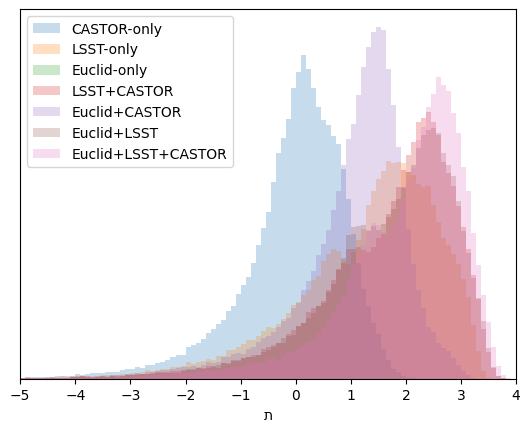

In [28]:
for os in available_os:
  plt.hist(just_tav[os], alpha=0.25, label=os, density=True, bins=np.linspace(-5, 4, 100))
plt.legend()
plt.xlim(-5,4)
plt.xlabel(chr(0x05ea))#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
plt.yticks([])
# plt.savefig(prepend+'all_combos_histogram.pdf')

In [ ]:
# for os in ['LSST-only','LSST+CASTOR','Euclid+LSST','Euclid+LSST+CASTOR']:
#   # with open(prepend+f"losses_for_{os}.pkl", "rb") as file:
#   #   saveinfo = pickle.load(file)
#   # testflow = FlowEnsemble(saveinfo['losses'])
#   testflow = ensembles[os]
#   plt.hist2d(catalogs[os]['z_true'], just_tav[os], bins=100)
#   plt.title(os)
#   plt.xlim(0, 3)
#   plt.ylim(-5, 4)
#   plt.show()

In [ ]:
# 'logprob' not in catalogs[os].columns.values

False

In [ ]:
flows = {}
for os in available_os:
  flows[os] = FlowEnsemble(file=f"pzflow_ensemble_for_{os}.pkl")

In [29]:
zbins = np.linspace(0, 3, 100)
avgtav = {}
errtav = {}
for os in available_os:
  print(os)
  plotran = np.empty_like(zbins)
  ploterr = np.empty_like(zbins)
  print(catalogs[os].columns)
  if 'logprob' not in catalogs[os].columns.values:
    catalogs[os]['logprob'] = just_tav[os]
    print(catalogs[os].columns)
  for i, zmin in enumerate(zbins[:-1]):
    zmax = zbins[i+1]
    subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
    # print((zmin, len(subset), zmax))
    vals = subset['logprob']
    mean = np.mean(vals)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std
  avgtav[os] = plotran
  errtav[os] = ploterr

CASTOR-only
Index(['z_true', 'g', 'uv-u', 'u-g'], dtype='object')
Index(['z_true', 'g', 'uv-u', 'u-g', 'logprob'], dtype='object')
LSST-only
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z'], dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'logprob'], dtype='object')
Euclid-only
Index(['z_true', 'v', 'v-y', 'y-j', 'j-h'], dtype='object')
Index(['z_true', 'v', 'v-y', 'y-j', 'j-h', 'logprob'], dtype='object')
LSST+CASTOR
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'uv-u', 'u-g'], dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'uv-u', 'u-g', 'logprob'], dtype='object')
Euclid+CASTOR
Index(['z_true', 'g', 'uv-u', 'u-g', 'v', 'v-y', 'y-j', 'j-h'], dtype='object')
Index(['z_true', 'g', 'uv-u', 'u-g', 'v', 'v-y', 'y-j', 'j-h', 'logprob'], dtype='object')
Euclid+LSST
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h'], dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h',
       'logprob'],
      dtype='object')
Euclid+LSST+CASTOR


Text(0, 0.5, 'ת')

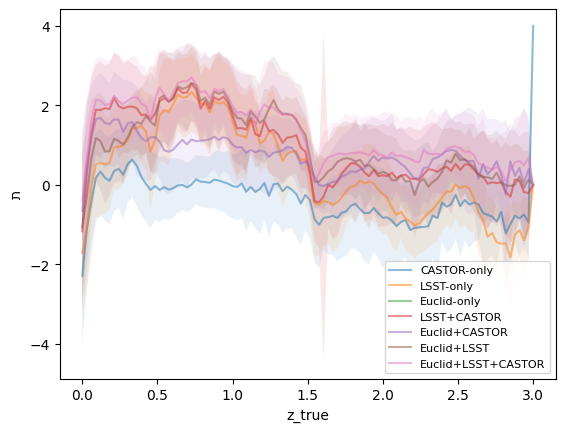

In [39]:
for os in available_os:
  plt.plot(zbins, avgtav[os], label=os, alpha=0.5)
  plt.fill_between(zbins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
# plt.ylim(-10, 5)
plt.legend(fontsize = 8)
plt.xlabel('z_true')
plt.ylabel(chr(0x05ea))
# plt.savefig(prepend+'all_combos_over_z.pdf')

In [ ]:
catalogs['Euclid-only']

,z_true,v,v-y,y-j,j-h,logprob
CASTOR_ID,,,,,,
3,0.2211,23.203628,-0.016871,-0.121814,-0.055555,-inf
12,0.7070,24.190875,0.605677,-0.100641,0.005671,-inf
73,0.4290,22.541518,0.458337,0.157455,-0.027302,-inf
74,1.5087,23.728690,0.578910,0.169981,-0.051920,-inf
85,1.0800,23.861097,0.725771,0.061637,-0.011445,-inf
...,...,...,...,...,...,...
964424,0.3275,20.022624,0.880555,0.322735,0.060411,-inf
964426,0.3230,23.598673,0.501241,0.117568,0.082705,-inf
964427,1.4726,23.889596,2.572259,0.754654,0.496406,-inf


In [ ]:
print(np.min(catalogs['Euclid+LSST+CASTOR']['g-r']))
print(np.max(catalogs['Euclid+LSST+CASTOR']['g-r']))

-2.7623690139796935
4.680951755903436


In [ ]:
# color space binned information gain

color_lim_min = np.min(catalogs['Euclid+LSST+CASTOR']['g-r'])
color_lim_max = np.max(catalogs['Euclid+LSST+CASTOR']['g-r'])

color_bins = np.linspace(color_lim_min, color_lim_max, 32)
avgtav = {}
errtav = {}
for os in available_os:
  print(os)
  plotran = np.empty_like(color_bins)
  ploterr = np.empty_like(color_bins)
  print(catalogs[os].columns)
  if 'logprob' not in catalogs[os].columns.values:
    catalogs[os]['logprob'] = just_tav[os]
    print(catalogs[os].columns)
  for i, zmin in enumerate(color_bins[:-1]):
    color_max = color_bins[i+1]
    subset = catalogs[os][(catalogs['Euclid+LSST+CASTOR']['g-r'] >= color_min) & (catalogs['Euclid+LSST+CASTOR']['g-r'] < color_max)]
    # print((zmin, len(subset), zmax))
    vals = subset['logprob']
    mean = np.mean(vals)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std
  avgtav[os] = plotran
  errtav[os] = ploterr

CASTOR-only
Index(['z_true', 'g', 'uv-u', 'u-g', 'logprob'], dtype='object')
LSST-only
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'logprob'], dtype='object')
Euclid-only
Index(['z_true', 'v', 'v-y', 'y-j', 'j-h', 'logprob'], dtype='object')
LSST+CASTOR
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'uv-u', 'u-g', 'logprob'], dtype='object')
Euclid+CASTOR
Index(['z_true', 'g', 'uv-u', 'u-g', 'v', 'v-y', 'y-j', 'j-h', 'logprob'], dtype='object')
Euclid+LSST
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h',
       'logprob'],
      dtype='object')
Euclid+LSST+CASTOR
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h', 'g',
       'uv-u', 'u-g', 'logprob'],
      dtype='object')


Text(0, 0.5, 'ת')

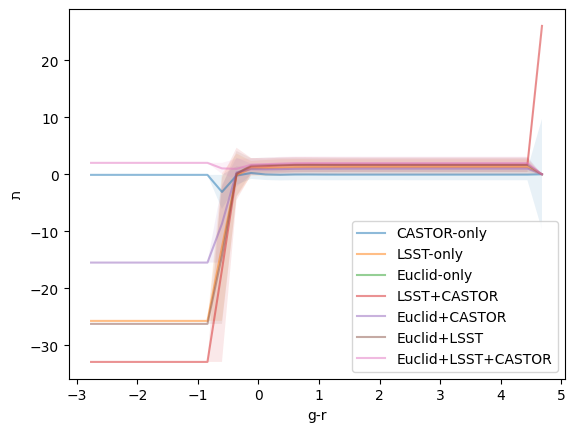

In [ ]:
for os in available_os:
  plt.plot(color_bins, avgtav[os], label=os, alpha=0.5)
  plt.fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
plt.legend()
plt.xlabel('g-r')
plt.ylabel(chr(0x05ea))


CASTOR-only
Index(['z_true', 'g', 'uv-u', 'u-g'], dtype='object')
Index(['z_true', 'g', 'uv-u', 'u-g', 'logprob'], dtype='object')
LSST-only
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z'], dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'logprob'], dtype='object')
Euclid-only
Index(['z_true', 'v', 'v-y', 'y-j', 'j-h'], dtype='object')
Index(['z_true', 'v', 'v-y', 'y-j', 'j-h', 'logprob'], dtype='object')
LSST+CASTOR
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'uv-u', 'u-g'], dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'uv-u', 'u-g', 'logprob'], dtype='object')
Euclid+CASTOR
Index(['z_true', 'g', 'uv-u', 'u-g', 'v', 'v-y', 'y-j', 'j-h'], dtype='object')
Index(['z_true', 'g', 'uv-u', 'u-g', 'v', 'v-y', 'y-j', 'j-h', 'logprob'], dtype='object')
Euclid+LSST
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h'], dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h',
       'logprob'],
      dtype='object')
Euclid+LSST+CASTOR


Text(0, 0.5, 'ת')

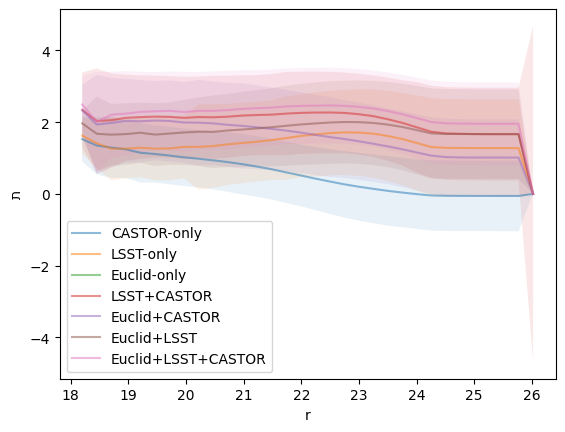

In [ ]:
# color space binned information gain


# 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h', 'g',
#       'uv-u', 'u-g']

col_diff = 'r'

color_lim_min = np.min(catalogs['Euclid+LSST+CASTOR'][col_diff])
color_lim_max = np.max(catalogs['Euclid+LSST+CASTOR'][col_diff])

color_bins = np.linspace(color_lim_min, color_lim_max, 32)
avgtav = {}
errtav = {}
for os in available_os:
  print(os)
  plotran = np.empty_like(color_bins)
  ploterr = np.empty_like(color_bins)
  print(catalogs[os].columns)
  if 'logprob' not in catalogs[os].columns.values:
    catalogs[os]['logprob'] = just_tav[os]
    print(catalogs[os].columns)
  for i, zmin in enumerate(color_bins[:-1]):
    color_max = color_bins[i+1]
    subset = catalogs[os][(catalogs['Euclid+LSST+CASTOR'][col_diff] >= color_min) & (catalogs['Euclid+LSST+CASTOR'][col_diff] < color_max)]
    # print((zmin, len(subset), zmax))
    vals = subset['logprob']
    mean = np.mean(vals)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std
  avgtav[os] = plotran
  errtav[os] = ploterr

for os in available_os:
  plt.plot(color_bins, avgtav[os], label=os, alpha=0.5)
  plt.fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
plt.legend()
plt.xlabel(col_diff)
plt.ylabel(chr(0x05ea))

CASTOR-only
Index(['z_true', 'g', 'uv-u', 'u-g', 'logprob'], dtype='object')
LSST-only
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'logprob'], dtype='object')
Euclid-only
Index(['z_true', 'v', 'v-y', 'y-j', 'j-h', 'logprob'], dtype='object')
LSST+CASTOR
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'uv-u', 'u-g', 'logprob'], dtype='object')
Euclid+CASTOR
Index(['z_true', 'g', 'uv-u', 'u-g', 'v', 'v-y', 'y-j', 'j-h', 'logprob'], dtype='object')
Euclid+LSST
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h',
       'logprob'],
      dtype='object')
Euclid+LSST+CASTOR
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h', 'g',
       'uv-u', 'u-g', 'logprob'],
      dtype='object')


Text(0, 0.5, 'ת')

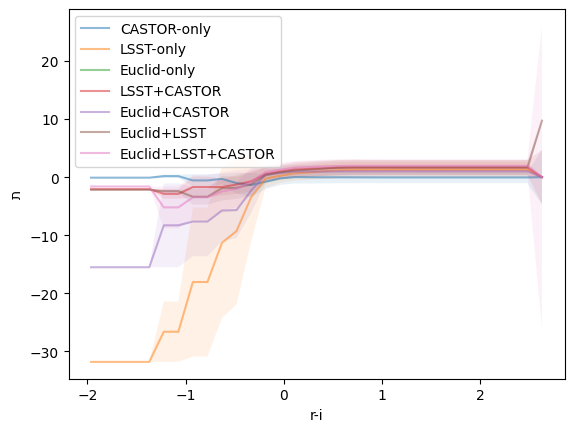

In [ ]:
# color space binned information gain


# 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h', 'g',
#       'uv-u', 'u-g']

col_diff = 'r-i'

color_lim_min = np.min(catalogs['Euclid+LSST+CASTOR'][col_diff])
color_lim_max = np.max(catalogs['Euclid+LSST+CASTOR'][col_diff])

color_bins = np.linspace(color_lim_min, color_lim_max, 32)
avgtav = {}
errtav = {}
for os in available_os:
  print(os)
  plotran = np.empty_like(color_bins)
  ploterr = np.empty_like(color_bins)
  print(catalogs[os].columns)
  if 'logprob' not in catalogs[os].columns.values:
    catalogs[os]['logprob'] = just_tav[os]
    print(catalogs[os].columns)
  for i, zmin in enumerate(color_bins[:-1]):
    color_max = color_bins[i+1]
    subset = catalogs[os][(catalogs['Euclid+LSST+CASTOR'][col_diff] >= color_min) & (catalogs['Euclid+LSST+CASTOR'][col_diff] < color_max)]
    # print((zmin, len(subset), zmax))
    vals = subset['logprob']
    mean = np.mean(vals)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std
  avgtav[os] = plotran
  errtav[os] = ploterr

for os in available_os:
  plt.plot(color_bins, avgtav[os], label=os, alpha=0.5)
  plt.fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
plt.legend()
plt.xlabel(col_diff)
plt.ylabel(chr(0x05ea))

In [ ]:
# maximum information gain galaxies - analog of point source/outliers.

np.where(np.abs(just_tav['LSST-only'] - just_tav['Euclid+LSST+CASTOR']) == np.max(np.abs(just_tav['LSST-only'] - just_tav['Euclid+LSST+CASTOR'])))

(array([1029]),)

In [ ]:
np.array(catalogs[os][col_diff])[1029]

-1.9635743579954834

In [41]:
worst_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['Euclid+LSST+CASTOR'])))[::-1][0:1000]
best_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['Euclid+LSST+CASTOR'])))[0:1000]

Text(0, 0.5, 'r-i')

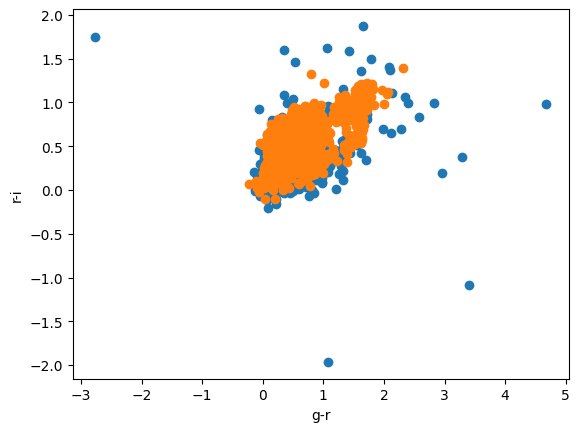

In [ ]:
plt.scatter(np.array(catalogs['Euclid+LSST+CASTOR']['g-r'])[worst_galaxies], np.array(catalogs['Euclid+LSST+CASTOR']['r-i'])[worst_galaxies])
plt.scatter(np.array(catalogs['Euclid+LSST+CASTOR']['g-r'])[best_galaxies], np.array(catalogs['Euclid+LSST+CASTOR']['r-i'])[best_galaxies])

plt.xlabel('g-r')
plt.ylabel('r-i')

(array([0.04006661, 0.0200333 , 0.20033304, 0.5208659 , 0.84139876,
        1.02169849, 1.0417318 , 0.84139876, 1.16193162, 1.36226466,
        0.86143206, 1.20199823, 1.42236457, 1.582631  , 1.38229796,
        1.78296404, 1.08179841, 0.74123224, 0.80133215, 0.5408992 ,
        0.40066608, 0.32053286, 0.22036634, 0.26043295, 0.14023313,
        0.10016652, 0.10016652, 0.        , 0.0200333 , 0.0200333 ]),
 array([-0.10703752, -0.05712064, -0.00720376,  0.04271312,  0.09263   ,
         0.14254688,  0.19246376,  0.24238063,  0.29229751,  0.34221439,
         0.39213127,  0.44204815,  0.49196503,  0.54188191,  0.59179879,
         0.64171567,  0.69163254,  0.74154942,  0.7914663 ,  0.84138318,
         0.89130006,  0.94121694,  0.99113382,  1.0410507 ,  1.09096758,
         1.14088445,  1.19080133,  1.24071821,  1.29063509,  1.34055197,
         1.39046885]),
 <BarContainer object of 30 artists>)

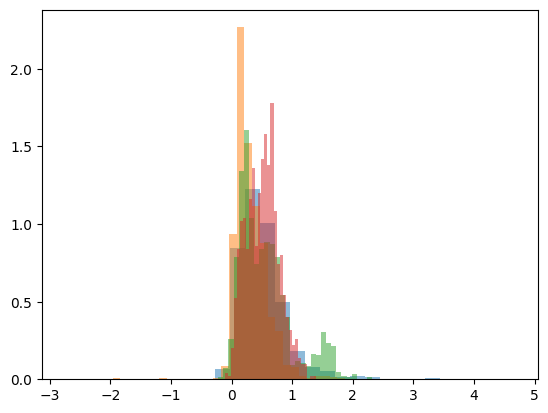

In [42]:
plt.hist(np.array(catalogs['Euclid+LSST+CASTOR']['g-r'])[worst_galaxies], bins = 30, density = True, alpha = 0.5)
plt.hist(np.array(catalogs['Euclid+LSST+CASTOR']['r-i'])[worst_galaxies], bins = 30, density = True, alpha = 0.5)

plt.hist(np.array(catalogs['Euclid+LSST+CASTOR']['g-r'])[best_galaxies], bins = 30, density = True, alpha = 0.5)
plt.hist(np.array(catalogs['Euclid+LSST+CASTOR']['r-i'])[best_galaxies], bins = 30, density = True, alpha = 0.5)

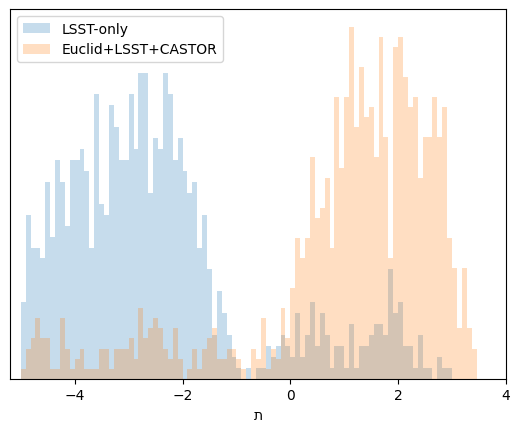

In [51]:
available_os = ['LSST-only', 'Euclid+LSST+CASTOR']

for os in available_os:
  plt.hist(just_tav[os][worst_galaxies], alpha=0.25, label=os, density=True, bins=np.linspace(-5, 4, 100))
plt.legend()
plt.xlim(-5.2,4)
plt.xlabel(chr(0x05ea))#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
plt.yticks([])
plt.show()

# for os in available_os:
#   plt.hist(just_tav[os][best_galaxies], alpha=0.25, label=os, density=True, bins=np.linspace(-5, 4, 100))
# plt.legend()
# plt.xlim(-5,4)
# plt.xlabel(chr(0x05ea))#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
# plt.yticks([])

In [ ]:
# loss

In [ ]:
# flowEns.info

In [ ]:
# mutual_information_lower_bound = flowEns.log_prob(cat_train, returnEnsemble=True)
# mutual_information_lower_bound2 = flowEns2.log_prob(cat_train, returnEnsemble=True)

plt.hist(np.mean(mutual_information_lower_bound, axis = 0), bins = np.linspace(0.8, 1.2, 5), histtype = 'step')
plt.hist(np.mean(mutual_information_lower_bound2, axis = 0), bins = np.linspace(0.8, 1.2, 5), histtype = 'step')


#plt.hist(mutual_information_lower_bound, bins=np.linspace(-16, 5, 100), alpha=0.5, histtype='step', density=False)

In [ ]:
available_os = ['Euclid-only', 'Euclid+CASTOR', 'Euclid+LSST+CASTOR', 'Euclid+LSST']

In [ ]:
cd '/content/drive/MyDrive/Research/CASTORpz/'

/content/drive/MyDrive/Research/CASTORpz


In [ ]:
names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')


In [ ]:
flows = {}
for os in available_os:
  flows[os] = FlowEnsemble(file=f"pzflow_ensemble_for_{os}.pkl")
# TODO: need to experiment with different fit parameters because this might be too smooth, also does it account for photometric errors?
# TODO: check that draws from flow look like original data


# load the catalogs
catalogs = dict()
for os in available_os:
    z_cat = pd.read_csv(f"dataset/run_{os}/zphot.cat", names=names_z, delim_whitespace=True, skiprows=1)
    phot_cat = pd.read_csv(f"dataset/run_{os}/test.cat", names=names_phot, delim_whitespace=True)
    cat = z_cat.merge(phot_cat)
    catalogs[os] = cat.dropna()

for which_os in available_os:
  mutual_information_lower_bound = all_milb[which_os].flatten()
  print((np.mean(mutual_information_lower_bound), np.std(mutual_information_lower_bound)))
  hist(mutual_information_lower_bound, bins=np.linspace(-16, 5, 100), alpha=0.5, histtype='step', 
       color=os_colors[which_os], label=os_names[which_os], density=False)
  xlabel(r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
# xlim(-10., 5.)
legend(loc='upper left')

FileNotFoundError: ignored

And now an error because it's looking at flows trained on catalogs with different keyword names?

In [ ]:
# this pzflow demo runs, so the problem is specific to our data

# import jax.numpy as jnp
# import matplotlib.pyplot as plt
# # import corner

# import pzflow
# from pzflow import Flow
# from pzflow.bijectors import Chain, ShiftBounds, RollingSplineCoupling
# from pzflow.distributions import Uniform
# from pzflow.examples import get_galaxy_data

# data = get_galaxy_data()

# # get minima and maxima for each column
# mins = jnp.array(data.min(axis=0))
# maxs = jnp.array(data.max(axis=0))

# # get the number of dimensions
# ndim = data.shape[1]

# # build the bijector
# bijector = Chain(
#     ShiftBounds(mins, maxs, B=4),
#     RollingSplineCoupling(ndim, B=5),
# )



# latent = Uniform(input_dim=ndim, B=5)


# flow = Flow(data.columns, bijector=bijector, latent=latent)

# # %%time 
# losses = flow.train(data, epochs=20, verbose=True)


Training 200 epochs 
Loss:
(0) 20.4908


KeyboardInterrupt: ignored

dependencies: pzflow, pandas, jax

In [ ]:
from pzflow import Flow
import jax.numpy as jnp
import pandas as pd 

import matplotlib.pyplot as plt

In [ ]:
from astropy.table import Table

## CASTOR COSMOS synthetic catalogs

In [ ]:
# load data

unp = Table.read("unperturbed_mags.fits")
mock = Table.read("ext_phot.fits")
mask = unp["Euclid_VIS_MAG"] <= 24.5

CASTOR_baseline = mock[mask] #ignoring training data outside the Euclid flux limit 

names_phot = ["ID", "photoz",
              "LSST_g_MAG", "LSST_g_MAGERR", 
              "LSST_r_MAG", "LSST_r_MAGERR",
              "LSST_i_MAG", "LSST_i_MAGERR", 
              "LSST_z_MAG", "LSST_z_MAGERR"
              "castor_uv_MAG", "castor_uv_MAGERR", 
              "castor_u_MAG", "castor_u_MAGERR", 
              "castor_g_MAG", "castor_g_MAGERR"]

available_os = ["baseline"]
names = [
    "baseline",
]

os_names = dict(zip(available_os, names))
colors = ["k"] #, "plum", "cornflowerblue", "#2ca02c", "gold", "tomato"]
os_colors = dict(zip(available_os, colors))

# put data in expected format for TLM 

LSST_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAG")
LSST_r_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAG")
LSST_i_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAG")
LSST_z_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAG")

LSST_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAGERR")
LSST_r_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAGERR")
LSST_i_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAGERR")
LSST_z_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAGERR")

CASTOR_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="CASTOR_g_MAG")
CASTOR_r_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="CASTOR_r_MAG")
CASTOR_i_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="CASTOR_i_MAG")
CASTOR_z_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="CASTOR_z_MAG")

CASTOR_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="CASTOR_g_MAGERR")
CASTOR_r_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="CASTOR_r_MAGERR")
CASTOR_i_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="CASTOR_i_MAGERR")
CASTOR_z_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="CASTOR_z_MAGERR")

ID = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="ID")
z_true = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="photoz")

df = pd.DataFrame({'CASTOR_ID': data_array_sorted_CASTOR_wID[:,0] , 'error': data_array_sorted_CASTOR_wID[:,1], 
                   'g-r': data_array_sorted_CASTOR_wID[:,2] - data_array_sorted_CASTOR_wID[:,3], 
                   'r-i': data_array_sorted_CASTOR_wID[:,3] - data_array_sorted_CASTOR_wID[:,4], 
                   'i-z': data_array_sorted_CASTOR_wID[:,4] - data_array_sorted_CASTOR_wID[:,5], 
                   'true_z': data_array_sorted_CASTOR_wID[:,6]})

In [ ]:
# load the catalogs
catalogs = dict()
for os in available_os:
    
#     cat = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, 
#                              'LSST_g_mag': LSST_g_mag, 'LSST_g_mag_ERR': LSST_g_mag_ERR, 
#                              'LSST_r_mag': LSST_r_mag, 'LSST_r_mag_ERR': LSST_r_mag_ERR, 
#                              'LSST_i_mag': LSST_i_mag, 'LSST_i_mag_ERR': LSST_i_mag_ERR, 
#                              'LSST_z_mag': LSST_z_mag, 'LSST_z_mag_ERR': LSST_z_mag_ERR, 
#                              'CASTOR_uv_mag': LSST_uv_mag, 'LSST_uv_mag_ERR': LSST_uv_mag_ERR, 
#                              'CASTOR_u_mag': LSST_u_mag, 'LSST_u_mag_ERR': LSST_u_mag_ERR, 
#               'CASTOR_g_mag': LSST_g_mag, 'LSST_g_mag_ERR': LSST_g_mag_ERR})
    
    # this will need to change to accomodate multiple catalogs, e.g. LSST only or LSST + CASTOR
    
    cat = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, 
                             'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag, 
                             'r-i': LSST_r_mag - LSST_i_mag, 
                             'i-z': LSST_i_mag - LSST_z_mag, 
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag; 
                             'u-g': CASTOR_u_mag - CASTOR_g_mag
                      })
    
    catalogs[os] = cat.dropna()

# Instantiate and Train 

### Does this run 'as is'?

In [ ]:
# first I create a bijector chain
# the first bijection is a standard scaler - but I'm not actually using it for standard scaling
#     I set the mean and std so that it maps the redshift range (0, 3.2) onto (-5, 5), which is 
#     the domain of the NeuralSplineCoupling
# the second bijection is a NeuralSplineCoupling. I told it to expect 6 conditions,
#     which will be the r mag and the galaxy colors
bijector = Chain(
    StandardScaler(np.atleast_1d(1.6), np.atleast_1d(0.32)),
    NeuralSplineCoupling(n_conditions=6)
)

# I set the latent distribution to a Uniform over (-5, 5)
# this range was chosen to match the NeuralSplineCoupling domain
# I chose a Uniform since all of the redshifts are drawn from a compact domain
latent = Uniform(1)

# create a dictionary that will hold all the ensembles
ensembles = dict()

# create the baseline flows
for os in available_os:

    # the data column is the one that is sampled and transformed by the flow
    data_columns = ["z_true"]
    # the conditional columns are the columns that the flow is conditioned on
    conditional_columns = ["r", "u-g", "g-r", "r-i", "i-z", "uv-u"] # different colors than LSST  

    # save some info with the flow
    info = f"Models z_true conditioned on galaxy colors and r mag from os {os}. K=16"

    # instantiate and save the flow
    flowEns = FlowEnsemble(data_columns = data_columns, 
                           conditional_columns = conditional_columns,
                           bijector = bijector,
                           latent = latent,
                           info = info,
                           N = 10)

    ensembles[os] = flowEns
    

for os, ens in ensembles.items():
    
    # get the data and make a train and test set
    cat = catalogs[os]
    cat_train = cat.sample(frac = 0.8)
    cat_test = cat.drop(cat_train.index)
    
    # train the flow on the given learning rate schedule
    loss1 = ens.train(cat_train, sample_errs=True,
                       optimizer = adam(step_size = 1e-3),
                       epochs = 100, seed = 123)
    loss2 = ens.train(cat_train, sample_errs=True,
                       optimizer = adam(step_size = 2e-4),
                       epochs = 100, seed = 312)
    loss3 = ens.train(cat_train, sample_errs=True,
                       optimizer = adam(step_size = 1e-4),
                       epochs = 50, seed = 231)
    
    losses = {fname : # for each flow trained in the ensemble...
                  [float(loss) # save the list of training losses
                   for lossDict in [loss1, loss2, loss3]
                   for loss in lossDict[fname]]
              for fname in loss1}
    
    # print the train and test loss
    train_loss = -np.mean(ens.log_prob(cat_train))
    test_loss = -np.mean(ens.log_prob(cat_test))
    print(os, train_loss, test_loss)
    
    # save the ensemble
    ens.save(f"trained_flows/pzflow_ensemble_for_{os}.pkl")
    # and the losses
    with open(f"trained_flows/losses_for_{os}.pkl", "wb") as file:
        pickle.dump({"losses": losses, 
                     "train loss": train_loss, 
                     "test loss": test_loss},
                    file)

# from github/aimalz/TheLastMetric/blob/master/training_flows_July23.ipynb

pull the data just to get formatting

In [ ]:
# !wget https://storage.googleapis.com/ahw2019/for_malz_and_lanusse.tar.gz
# !tar -xzf for_malz_and_lanusse.tar.gz
# !mv for_malz_and_lanusse dataset



more dataset/readme.txt



# list of available catalogs
available_os = ["run_1_4_y10", "run_4_38_y10", "run_10_92_y10", "run_4_34_y10", "run_7_61_y10", "run_9_86_y10"]
names = [
    "baseline_v1_5_10yrs",
    "footprint_stuck_rollingv1_5_10yrs",
    "ddf_heavy_nexp2_v1_6_10yrs",
    "footprint_newAv1_5_10yrs",
    "third_obs_pt60v1_5_10yrs",
    "barebones_v1_6_10yrs",
]
os_names = dict(zip(available_os, names))
colors = ["k", "plum", "cornflowerblue", "#2ca02c", "gold", "tomato"]
os_colors = dict(zip(available_os, colors))


# column names of the catalogs
names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
names_phot=(
    'ID', 'z_true', 
    'u', 'u_err',
    'g', 'g_err',
    'r', 'r_err',
    'i', 'i_err',
    'z', 'z_err',
    'y', 'y_err',
    'u-g', 'u-g_err',
    'g-r', 'g-r_err',
    'r-i', 'r-i_err',
    'i-z', 'i-z_err',
    'z-y', 'z-y_err',
)

# load the catalogs
catalogs = dict()
for os in available_os:
    z_cat = pd.read_csv(f"dataset/{os}/zphot.cat", names=names_z, delim_whitespace=True, skiprows=1)
    phot_cat = pd.read_csv(f"dataset/{os}/test.cat", names=names_phot, delim_whitespace=True)
    cat = z_cat.merge(phot_cat)
    catalogs[os] = cat.dropna()

instantiate the model of the photometric space, train it on the catalogs for LSST with and without CASTOR, and save it (two versions rather than 6 OSs)

In [ ]:
# first I create a bijector chain
# the first bijection is a standard scaler - but I'm not actually using it for standard scaling
#     I set the mean and std so that it maps the redshift range (0, 3.2) onto (-5, 5), which is 
#     the domain of the NeuralSplineCoupling
# the second bijection is a NeuralSplineCoupling. I told it to expect 6 conditions,
#     which will be the r mag and the galaxy colors
bijector = Chain(
    StandardScaler(np.atleast_1d(1.6), np.atleast_1d(0.32)),
    NeuralSplineCoupling(n_conditions=6)
)

# I set the latent distribution to a Uniform over (-5, 5)
# this range was chosen to match the NeuralSplineCoupling domain
# I chose a Uniform since all of the redshifts are drawn from a compact domain
latent = Uniform((-5, 5))

# create a dictionary that will hold all the ensembles
ensembles = dict()

# create the baseline flows
for os in available_os:

    # the data column is the one that is sampled and transformed by the flow
    data_columns = ["z_true"]
    # the conditional columns are the columns that the flow is conditioned on
    conditional_columns = ["r", "u-g", "g-r", "r-i", "i-z", "z-y"]

    # save some info with the flow
    info = f"Models z_true conditioned on galaxy colors and r mag from os {os}. K=16"

    # instantiate and save the flow
    flowEns = FlowEnsemble(data_columns = data_columns, 
                           conditional_columns = conditional_columns,
                           bijector = bijector,
                           latent = latent,
                           info = info,
                           N = 10)

    ensembles[os] = flowEns
    
    
    
    
%%time

for os, ens in ensembles.items():
    
    # get the data and make a train and test set
    cat = catalogs[os]
    cat_train = cat.sample(frac = 0.8)
    cat_test = cat.drop(cat_train.index)
    
    # train the flow on the given learning rate schedule
    loss1 = ens.train(cat_train, sample_errs=True,
                       optimizer = adam(step_size = 1e-3),
                       epochs = 100, seed = 123)
    loss2 = ens.train(cat_train, sample_errs=True,
                       optimizer = adam(step_size = 2e-4),
                       epochs = 100, seed = 312)
    loss3 = ens.train(cat_train, sample_errs=True,
                       optimizer = adam(step_size = 1e-4),
                       epochs = 50, seed = 231)
    
    losses = {fname : # for each flow trained in the ensemble...
                  [float(loss) # save the list of training losses
                   for lossDict in [loss1, loss2, loss3]
                   for loss in lossDict[fname]]
              for fname in loss1}
    
    # print the train and test loss
    train_loss = -np.mean(ens.log_prob(cat_train))
    test_loss = -np.mean(ens.log_prob(cat_test))
    print(os, train_loss, test_loss)
    
    # save the ensemble
    ens.save(f"trained_flows/pzflow_ensemble_for_{os}.pkl")
    # and the losses
    with open(f"trained_flows/losses_for_{os}.pkl", "wb") as file:
        pickle.dump({"losses": losses, 
                     "train loss": train_loss, 
                     "test loss": test_loss},
                    file)

# from github/aimalz/TheLastMetric/blob/master/MAFVariationalMutualInformationPzFlow.ipynb

open the models of redshift-photometry space and the catalogs

In [ ]:
flows = {}
for os in available_os:
  flows[os] = Flow(file=f"trained_flows/flow_for_run_{os}.pkl")
# TODO: need to experiment with different fit parameters because this might be too smooth, also does it account for photometric errors?
# TODO: check that draws from flow look like original data


# load the catalogs
catalogs = dict()
for os in available_os:
    z_cat = pd.read_csv(f"dataset/run_{os}/zphot.cat", names=names_z, delim_whitespace=True, skiprows=1)
    phot_cat = pd.read_csv(f"dataset/run_{os}/test.cat", names=names_phot, delim_whitespace=True)
    cat = z_cat.merge(phot_cat)
    catalogs[os] = cat.dropna()
    
    

evaluate the posteriors for each galaxy (totally forgot we had to do this)

In [ ]:
# # this just makes the posteriors for plotting, not sure why it uses so much memory. . .
# tx = np.linspace(0,3.5,100)
# all_logp = {}
# for which_os in available_os:
#   flow = flows[which_os]
#   cat = catalogs[which_os]
#   logp = flow.posterior(flow.info["condition_scaler"](cat), column="z_true", grid=tx)
#   all_logp[which_os] = logp
    
    

In [ ]:
all_milb = {}
for which_os in available_os:
  phot_cat = catalogs[which_os]

  mutual_information_lower_bound = flows[which_os].log_prob(flows[which_os].info["condition_scaler"](phot_cat))
  all_milb[which_os] = mutual_information_lower_bound
  print((os_names[which_os], np.sum(mutual_information_lower_bound)))
# TODO: make this an actual expected value rather than just sum
# also, shouldn't it be sum of exponential of metric value, since it should never penalize a negative value?

KEY PLOT: distribution of metric values for same galaxies with and without CASTOR

In [ ]:
# surprisingly not so different from one another
for which_os in available_os:
  mutual_information_lower_bound = all_milb[which_os].flatten()
  print((np.mean(mutual_information_lower_bound), np.std(mutual_information_lower_bound)))
  hist(mutual_information_lower_bound, bins=np.linspace(-16, 5, 100), alpha=0.5, histtype='step', 
       color=os_colors[which_os], label=os_names[which_os], density=False)
  xlabel(r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
# xlim(-10., 5.)
legend(loc='upper left')
# semilogy()

KEY PLOT: look at per-galaxy metric values as a function of redshift, then photometry

In [ ]:
fig, axs = plt.subplots(len(available_os), 1, figsize=(5, 5*len(available_os)))
for i, which_os in enumerate(available_os):
  axs[i].hist2d(z_cats[which_os]['z_true'], all_milb[which_os].flatten(), bins=[np.linspace(0., 3., 50), np.linspace(-5., 5., 100)])
  axs[i].set_xlabel('redshift')
  axs[i].set_ylabel(r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  axs[i].set_title(os_names[which_os])
# they're different, but not visibly so
# TODO: plot violins of metric as a function of binned redshift so they're all on one set of axes? or quantiles because outlers? or box/whisker https://matplotlib.org/stable/gallery/pyplots/boxplot_demo_pyplot.html?
# TODO: normalize within redshift bins to get these on one set of axes?
# TODO sort of want sum of metric values in redshift bins, no?

take expected value of the approximated posteriors, which is the mutual information lower bound

In [ ]:
# something isn't right about the autocalculation of moments so doing it by hand
def calc_moment(vals, k):
  n = len(vals)
  outval = np.sum(vals**k) / float(n)
  return float(outval)

which_moments = range(0, 5)
moment_res = {}
for which_os in available_os:
  # print((np.mean(all_milb[which_os]), np.std(all_milb[which_os])))
  moment_res[which_os] = []
  for i in which_moments:
    moment_res[which_os].append(calc_moment(all_milb[which_os], k=i))#sps.mstats.moment(all_milb[which_os], moment=which_moments[i], axis=0))
# print(moment_res)

# from github/aimalz/TheLastMetric/blob/master/FigureTLMvsRedshift.ipynb

KEY PLOT: distribution of TLM values with and without CASTOR including model uncertainty

In [ ]:
%pylab inline
from utils import load_data, compute_last_metric
import corner
from pzflow import Flow


# Loading data
z_cats, phot_cats, available_os, os_names, os_colors = load_data()


# Loading pre-trained flows
flows = {}
for os in available_os:
  flows[os] = [Flow(file=f"trained_flows/flow_for_run_{os}_%d.pkl"%(i+1) ) for i in range(10)]


# Computing metric for each observing strategy
all_tlm = {}
for which_os in available_os:
  all_tlm[which_os] = np.stack([(compute_last_metric(f,
                                          phot_cats[which_os],
                                          z_cats[which_os], entropy_nbins=60)) for f in flows[which_os] ], axis=0)
  print((os_names[which_os], np.mean(all_tlm[which_os]), np.std(np.mean(all_tlm[which_os], axis=1))))
    
    
    

figure(figsize=(7,5))
for which_os in available_os:
  hist(np.mean(all_tlm[which_os],axis=1), 32, range=[2.95, 3.35], alpha=0.6,
       color=os_colors[which_os], label=os_names[which_os])
  axvline(np.mean(all_tlm[which_os]), color=os_colors[which_os], linewidth=2)
legend(ncol=2)
xlabel(chr(0x05ea))
savefig('metrics.pdf', bbox_inches = 'tight', pad_inches = 0 )